# Birch clustering algorithm comparison

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn.cluster import Birch

In [7]:
def compare_clustering_methods(data, true_k):
    #birch = Birch(threshold=0.1, branching_factor=50, leaf_size=50, cluster_method='kmeans')
    birch = Birch(threshold=0.1,n_clusters=true_k)
    labels = birch.fit_predict(data)
    kmeans = KMeans(true_k, init='k-means++')
    kmeans_labels = kmeans.fit_predict(data)
    dbscan = DBSCAN()
    dbscan_labels = dbscan.fit_predict(data)
    mini_kmeans = MiniBatchKMeans(n_clusters=true_k)
    mini_kmeans_labels = mini_kmeans.fit_predict(data)
    return labels, kmeans_labels, dbscan_labels, mini_kmeans_labels

For each dataset I perform the following measurements:
- I apply the clustering algorithms (Kmeans with kmeans++ initialization, Mini batch kmeans, DBSCAN)
- I measure the execution time
- I compare visually the plots (do some clustering algorithms only find convex clusters?)
- I compute the normalized mutual information w.r.t. the ground truth

## Grid data (convex clusters)

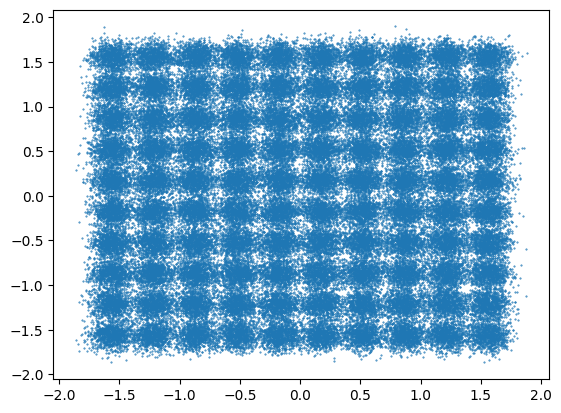

In [3]:
data = pd.read_csv('data/birch1.txt', sep=r"\s+").to_numpy()
data = (data - data.mean(0))/data.std(0)
true_k = 100
plt.scatter(data[:, 0], data[:, 1], s=0.2)
plt.show()

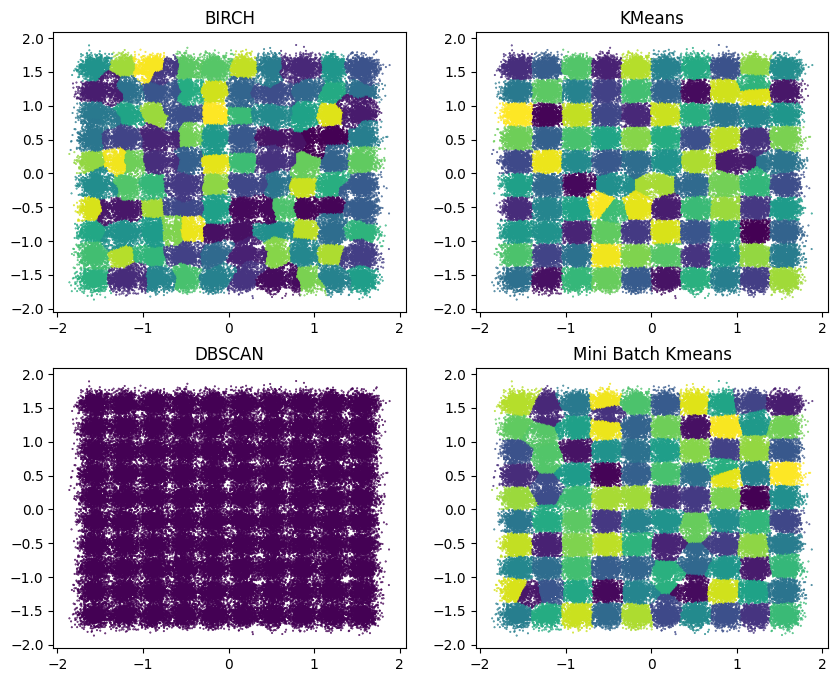

In [8]:
labels, kmeans_labels, dbscan_labels, mini_kmeans_labels = compare_clustering_methods(data, true_k)
size = 0.2
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.scatter(data[:, 0], data[:, 1], c=labels, s = size)
plt.title("BIRCH")
plt.subplot(2,2,2)
plt.scatter(data[:, 0], data[:, 1], c=kmeans_labels, s = size)
plt.title("KMeans")
plt.subplot(2,2,3)
plt.scatter(data[:, 0], data[:, 1], c=dbscan_labels, s = size)
plt.title("DBSCAN")
plt.subplot(2,2,4)
plt.scatter(data[:, 0], data[:, 1], c=mini_kmeans_labels, s = size)
plt.title("Mini Batch Kmeans")
plt.show()

## Spiral data (non convex clusters)

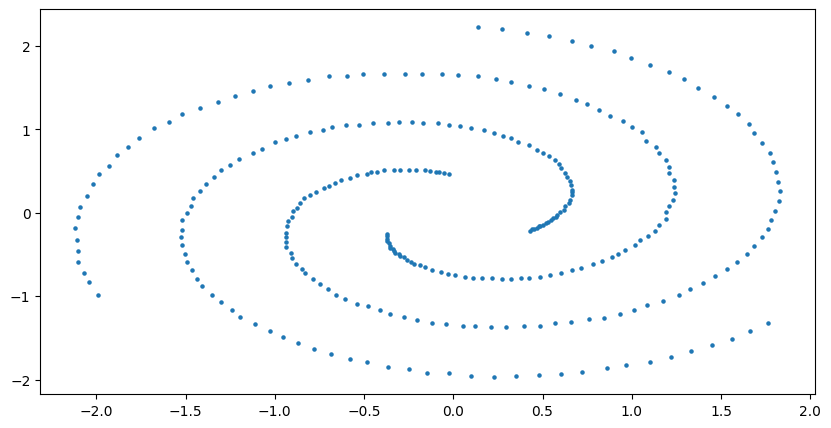

In [9]:
data = pd.read_csv('data/spiral.txt', sep=r"\s+").to_numpy()
data = (data - data.mean(0))/data.std(0)
true_k = 3
size = 5
plt.figure(figsize=(10,5))
plt.scatter(data[:, 0], data[:, 1], s=size)
plt.show()


## Sine curve data